# カスタムコンポーネント チュートリアル

このチュートリアルでは, `statphys-ml` シミュレーションフレームワークで使用する**カスタムデータセット**, **カスタムモデル**, **カスタム損失関数**の作成方法を解説する.

## 目次
1. [概要](#1-概要)
2. [カスタムデータセット](#2-カスタムデータセット)
3. [カスタムモデル](#3-カスタムモデル)
4. [カスタム損失関数](#4-カスタム損失関数)
5. [カスタムコンポーネントでシミュレーション実行](#5-カスタムコンポーネントでシミュレーション実行)
6. [まとめ](#6-まとめ)

## 1. 概要

`statphys-ml` パッケージは拡張性を考慮して設計されている. 以下のコンポーネントを独自に作成可能である:

- **データセット**: Teacher-Studentモデル用のカスタムデータ生成
- **モデル**: カスタムニューラルネットワークアーキテクチャ
- **損失関数**: 正則化を含むカスタム目的関数

すべてのカスタムコンポーネントは基底クラスを継承し, 統一されたインターフェースに従う.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import statphys
from statphys.utils import fix_seed

# 再現性のためシードを固定
fix_seed(42)

print(f"StatPhys-ML バージョン: {statphys.__version__}")

StatPhys-ML バージョン: 0.1.0


---
## 2. カスタムデータセット

カスタムデータセットを作成するには, `BaseDataset` を継承し, 以下を実装する:
- `generate_sample()`: 1つの (x, y) ペアを生成
- `get_teacher_params()`: 秩序パラメータ計算用の教師パラメータを返す

### 例: 多項式教師データセット

教師が多項式関数であるデータセットを作成する:
$$y = w_0^\top x + w_1^\top (x \odot x) + \epsilon$$

In [2]:
from statphys.dataset.base import BaseDataset
from typing import Any


class PolynomialTeacherDataset(BaseDataset):
    """
    多項式教師を持つデータセット: y = w0'x + w1'(x⊙x) + ノイズ
    
    シンプルな非線形Teacher-Student設定.
    """
    
    def __init__(
        self,
        d: int,
        rho_linear: float = 1.0,    # 線形重みのノルム
        rho_quadratic: float = 0.5,  # 二次重みのノルム
        eta: float = 0.1,            # ノイズ分散
        device: str = "cpu",
        **kwargs: Any,
    ):
        super().__init__(d=d, device=device, **kwargs)
        
        self.rho_linear = rho_linear
        self.rho_quadratic = rho_quadratic
        self.eta = eta
        
        # 教師重みを初期化
        # 線形重み: ||w0||^2 / d = rho_linear
        self.W0 = torch.randn(d, 1, device=self.device, dtype=self.dtype)
        self.W0 = self.W0 / torch.norm(self.W0) * np.sqrt(d * rho_linear)
        
        # 二次重み: ||w1||^2 / d = rho_quadratic
        self.W1 = torch.randn(d, 1, device=self.device, dtype=self.dtype)
        self.W1 = self.W1 / torch.norm(self.W1) * np.sqrt(d * rho_quadratic)
        
        # 教師パラメータを保存
        self._teacher_params = {
            "W0": self.W0,
            "W1": self.W1,
            "rho_linear": rho_linear,
            "rho_quadratic": rho_quadratic,
            "rho": rho_linear,  # 互換性のため
            "eta": eta,
        }
    
    def generate_sample(self) -> tuple[torch.Tensor, torch.Tensor]:
        """
        1つのサンプルを生成.
        
        Returns:
            x: 形状 (d,) の入力
            y: 出力 (スカラー)
        """
        # ガウス入力を生成
        x = torch.randn(self.d, device=self.device, dtype=self.dtype) / np.sqrt(self.d)
        
        # 教師出力を計算
        linear_part = (x @ self.W0).squeeze()      # w0'x
        quadratic_part = ((x * x) @ self.W1).squeeze()  # w1'(x⊙x)
        
        # ノイズを追加
        noise = torch.randn(1, device=self.device, dtype=self.dtype).squeeze() * np.sqrt(self.eta)
        
        y = linear_part + quadratic_part + noise
        
        return x, y
    
    def get_teacher_params(self) -> dict[str, Any]:
        """
        教師パラメータを返す.
        
        秩序パラメータの計算に使用される.
        """
        return self._teacher_params
    
    def __repr__(self) -> str:
        return (f"PolynomialTeacherDataset(d={self.d}, "
                f"rho_linear={self.rho_linear}, "
                f"rho_quadratic={self.rho_quadratic}, "
                f"eta={self.eta})")

In [3]:
# カスタムデータセットをテスト
d = 100
custom_dataset = PolynomialTeacherDataset(
    d=d,
    rho_linear=1.0,
    rho_quadratic=0.3,
    eta=0.1,
)

print(f"データセット: {custom_dataset}")
print(f"\n教師パラメータ:")
for key, value in custom_dataset.get_teacher_params().items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: shape={value.shape}, norm^2/d={torch.sum(value**2).item()/d:.4f}")
    else:
        print(f"  {key}: {value}")

# サンプルを生成
X, y = custom_dataset.generate_dataset(n_samples=200)
print(f"\n生成データ: X.shape={X.shape}, y.shape={y.shape}")
print(f"y統計: mean={y.mean():.4f}, std={y.std():.4f}")

データセット: PolynomialTeacherDataset(d=100, rho_linear=1.0, rho_quadratic=0.3, eta=0.1)

教師パラメータ:
  W0: shape=torch.Size([100, 1]), norm^2/d=1.0000
  W1: shape=torch.Size([100, 1]), norm^2/d=0.3000
  rho_linear: 1.0
  rho_quadratic: 0.3
  rho: 1.0
  eta: 0.1

生成データ: X.shape=torch.Size([200, 100]), y.shape=torch.Size([200])
y統計: mean=0.1017, std=1.0014


---
## 3. カスタムモデル

カスタムモデルを作成するには, `BaseModel` を継承し, 以下を実装する:
- `forward()`: 順伝播
- `get_weight_vector()`: 学習可能な重みをフラットなテンソルとして返す

### 例: 二次モデル

線形項と二次項の両方を含むモデル:
$$\hat{y} = w^\top x + v^\top (x \odot x)$$

In [4]:
from statphys.model.base import BaseModel


class QuadraticModel(BaseModel):
    """
    線形項と二次項を持つモデル: y = w'x + v'(x⊙x)
    
    このモデルは線形と二次のパターンの両方を学習可能.
    """
    
    def __init__(
        self,
        d: int,
        init_scale: float = 0.01,
        **kwargs: Any,
    ):
        super().__init__(d=d, **kwargs)
        
        self.init_scale = init_scale
        
        # 線形重み
        self.W = nn.Parameter(torch.randn(d, 1) * init_scale)
        
        # 二次重み
        self.V = nn.Parameter(torch.randn(d, 1) * init_scale)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        順伝播.
        
        Args:
            x: 形状 (batch, d) または (d,) の入力
        
        Returns:
            形状 (batch,) またはスカラーの出力
        """
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # 線形部分
        linear = (x @ self.W).squeeze(-1)  # (batch,)
        
        # 二次部分: x⊙x
        quadratic = ((x * x) @ self.V).squeeze(-1)  # (batch,)
        
        output = linear + quadratic
        
        return output.squeeze() if output.shape[0] == 1 else output
    
    def get_weight_vector(self) -> torch.Tensor:
        """
        すべての重みを1つのベクトルとして取得.
        
        秩序パラメータ計算のためにWとVを連結する.
        """
        return torch.cat([self.W.flatten(), self.V.flatten()])
    
    def __repr__(self) -> str:
        return f"QuadraticModel(d={self.d}, params={self.num_parameters})"

In [5]:
# カスタムモデルをテスト
custom_model = QuadraticModel(d=d)

print(f"モデル: {custom_model}")
print(f"パラメータ数: {custom_model.num_parameters}")
print(f"  - 線形重み (W): {custom_model.W.numel()}")
print(f"  - 二次重み (V): {custom_model.V.numel()}")

# 順伝播をテスト
x_test = torch.randn(10, d) / np.sqrt(d)
y_pred = custom_model(x_test)
print(f"\n順伝播: input shape={x_test.shape}, output shape={y_pred.shape}")

モデル: QuadraticModel(d=100, params=200)
パラメータ数: 200
  - 線形重み (W): 100
  - 二次重み (V): 100

順伝播: input shape=torch.Size([10, 100]), output shape=torch.Size([10])


---
## 4. カスタム損失関数

カスタム損失を作成するには, `BaseLoss` を継承し, 以下を実装する:
- `_compute_loss()`: メイン損失項を計算 (リダクションなし)

基底クラスが以下を処理する:
- リダクション (mean, sum, none)
- 正則化の計算

### 例: カスタム閾値を持つロバストHuber風損失

In [6]:
from statphys.loss.base import BaseLoss


class CustomRobustLoss(BaseLoss):
    """
    MSEと絶対誤差の間を滑らかに遷移するカスタムロバスト損失.
    
    L(r) = {
        r^2 / 2                        if |r| < delta
        delta * |r| - delta^2 / 2      otherwise
    }
    
    カスタマイズ可能なパラメータを持つHuber損失に類似.
    """
    
    def __init__(
        self,
        delta: float = 1.0,
        reg_param: float = 0.0,
        reduction: str = "mean",
        **kwargs: Any,
    ):
        super().__init__(reg_param=reg_param, reduction=reduction, **kwargs)
        self.delta = delta
    
    def _compute_loss(
        self,
        y_pred: torch.Tensor,
        y_true: torch.Tensor,
    ) -> torch.Tensor:
        """
        ロバスト損失を計算.
        
        Args:
            y_pred: 予測値
            y_true: 真値
        
        Returns:
            損失テンソル (リダクションなし)
        """
        residual = y_pred - y_true
        abs_residual = torch.abs(residual)
        
        # 二次領域: |r| < delta
        quadratic = 0.5 * residual**2
        
        # 線形領域: |r| >= delta
        linear = self.delta * abs_residual - 0.5 * self.delta**2
        
        # 滑らかな選択
        loss = torch.where(abs_residual < self.delta, quadratic, linear)
        
        return loss
    
    def __repr__(self) -> str:
        return f"CustomRobustLoss(delta={self.delta}, reg_param={self.reg_param})"

損失関数: CustomRobustLoss(delta=0.5, reg_param=0.01)


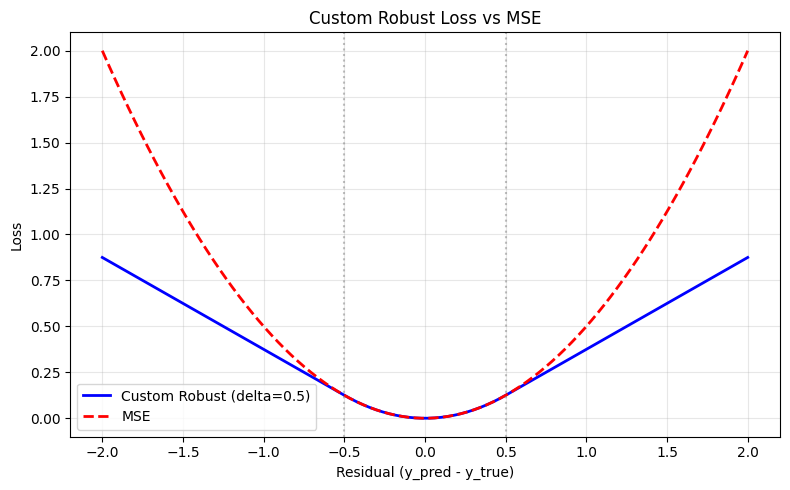

In [7]:
# カスタム損失をテスト
custom_loss = CustomRobustLoss(delta=0.5, reg_param=0.01)

print(f"損失関数: {custom_loss}")

# 異なる残差での挙動を比較
residuals = torch.linspace(-2, 2, 100)
y_pred = residuals
y_true = torch.zeros_like(residuals)

# モデルなしで損失を計算 (正則化なし)
loss_values = custom_loss._compute_loss(y_pred, y_true)

# 比較のためMSEも計算
mse_values = 0.5 * residuals**2

# 比較をプロット
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(residuals.numpy(), loss_values.numpy(), 'b-', linewidth=2, label=f'Custom Robust (delta={custom_loss.delta})')
ax.plot(residuals.numpy(), mse_values.numpy(), 'r--', linewidth=2, label='MSE')
ax.axvline(x=custom_loss.delta, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=-custom_loss.delta, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Residual (y_pred - y_true)')
ax.set_ylabel('Loss')
ax.set_title('Custom Robust Loss vs MSE')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 5. カスタムコンポーネントでシミュレーション実行

すべてのカスタムコンポーネントを使ってシミュレーションを実行する.

### 重要: カスタム秩序パラメータ関数

カスタムモデルを使用する場合, そのモデル固有の秩序パラメータを計算するカスタム `calc_order_params` 関数を提供する必要がある.

In [8]:
def custom_order_params(dataset, model) -> list[float]:
    """
    QuadraticModel用の秩序パラメータを計算するカスタム関数.
    
    この関数は訓練後に呼び出され, 以下を受け取る:
    - dataset: データセットインスタンス
    - model: 訓練済みモデルインスタンス
    
    Returns:
        秩序パラメータ値のリスト: [m_linear, m_quad, q_linear, q_quad, eg]
    """
    teacher_params = dataset.get_teacher_params()
    W0 = teacher_params["W0"]
    W1 = teacher_params["W1"]
    rho_l = teacher_params["rho_linear"]
    rho_q = teacher_params["rho_quadratic"]
    eta = teacher_params["eta"]
    d = dataset.d
    
    # モデルの重みを取得
    W = model.W.detach()
    V = model.V.detach()
    
    # オーバーラップを計算
    m_linear = (W.flatten() @ W0.flatten()).item() / d
    m_quad = (V.flatten() @ W1.flatten()).item() / d
    q_linear = torch.sum(W**2).item() / d
    q_quad = torch.sum(V**2).item() / d
    
    # 汎化誤差の推定
    eg = 0.5 * (rho_l + q_linear - 2 * m_linear)
    eg += 0.5 * (rho_q + q_quad - 2 * m_quad)
    eg += 0.5 * eta
    
    return [m_linear, m_quad, q_linear, q_quad, eg]


print("カスタム秩序パラメータ関数を定義した.")
print("戻り値: [m_linear, m_quad, q_linear, q_quad, eg]")

カスタム秩序パラメータ関数を定義した.
戻り値: [m_linear, m_quad, q_linear, q_quad, eg]


In [9]:
from statphys.simulation import ReplicaSimulation, SimulationConfig

# 設定
d = 200  # 入力次元
fix_seed(42)

print("="*60)
print("カスタムコンポーネントによるシミュレーション")
print("="*60)

カスタムコンポーネントによるシミュレーション


In [10]:
# ステップ1: カスタムデータセットを作成
print("\n[ステップ1] カスタムデータセットを作成...")
dataset = PolynomialTeacherDataset(
    d=d,
    rho_linear=1.0,
    rho_quadratic=0.3,
    eta=0.1,
)
print(f"  {dataset}")


[ステップ1] カスタムデータセットを作成...
  PolynomialTeacherDataset(d=200, rho_linear=1.0, rho_quadratic=0.3, eta=0.1)


In [11]:
# ステップ2: カスタム損失を作成
print("\n[ステップ2] カスタム損失関数を作成...")
loss_fn = CustomRobustLoss(delta=0.5, reg_param=0.01)
print(f"  {loss_fn}")


[ステップ2] カスタム損失関数を作成...
  CustomRobustLoss(delta=0.5, reg_param=0.01)


In [12]:
# ステップ3: シミュレーションを設定
print("\n[ステップ3] シミュレーションを設定...")
config = SimulationConfig.for_replica(
    alpha_range=(0.5, 4.0),
    alpha_steps=8,
    n_seeds=3,
    lr=0.01,
    max_iter=10000,
    tol=1e-5,
    patience=50,
    reg_param=0.01,
    verbose=True,
    verbose_interval=5000,
)
print(f"  alpha range: {config.alpha_range}")
print(f"  alpha steps: {config.alpha_steps}")
print(f"  seeds: {config.n_seeds}")


[ステップ3] シミュレーションを設定...
  alpha range: (0.5, 4.0)
  alpha steps: 8
  seeds: 3


In [13]:
# ステップ4: カスタム秩序パラメータ関数でシミュレーションを実行
print("\n[ステップ4] シミュレーションを実行...")
sim = ReplicaSimulation(config)

results = sim.run(
    dataset=dataset,
    model_class=QuadraticModel,           # カスタムモデルクラス
    loss_fn=loss_fn,                      # カスタム損失インスタンス
    calc_order_params=custom_order_params,  # カスタム秩序パラメータ関数
)

print("\n  シミュレーション完了!")


[ステップ4] シミュレーションを実行...
【TRIAL 1/3, SEED 100】


  α=0.50: Converged at iteration 67


  α=1.00: Converged at iteration 58
  α=1.50: Converged at iteration 54
  α=2.00: Converged at iteration 52


  α=2.50: Converged at iteration 51
  α=3.00: Converged at iteration 51


  α=3.50: Converged at iteration 51
  α=4.00: Converged at iteration 51
【TRIAL 2/3, SEED 101】
  α=0.50: Converged at iteration 67


  α=1.00: Converged at iteration 59


  α=1.50: Converged at iteration 53
  α=2.00: Converged at iteration 51
  α=2.50: Converged at iteration 51


  α=3.00: Converged at iteration 51
  α=3.50: Converged at iteration 51


  α=4.00: Converged at iteration 51
【TRIAL 3/3, SEED 102】
  α=0.50: Converged at iteration 66


  α=1.00: Converged at iteration 58
  α=1.50: Converged at iteration 54
  α=2.00: Converged at iteration 52


  α=2.50: Converged at iteration 51
  α=3.00: Converged at iteration 51


  α=3.50: Converged at iteration 51
  α=4.00: Converged at iteration 51

  シミュレーション完了!



[ステップ5] 結果を可視化...
  秩序パラメータ形状: (8, 5)
  秩序パラメータ: [m_linear, m_quad, q_linear, q_quad, eg]


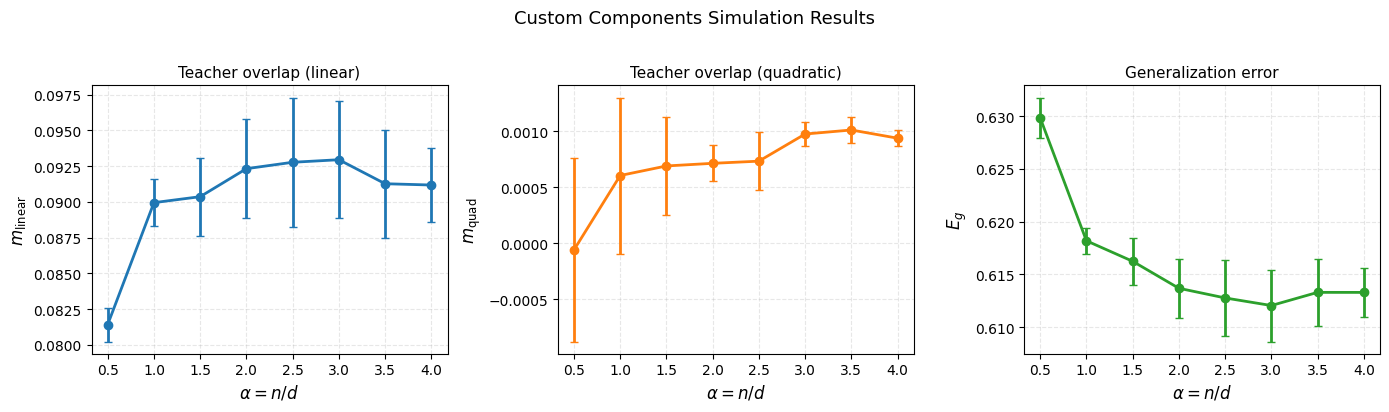

In [14]:
# ステップ5: 結果を可視化
print("\n[ステップ5] 結果を可視化...")

alpha_values = np.array(results.experiment_results["alpha_values"])
op_mean = np.array(results.experiment_results["order_params_mean"])
op_std = np.array(results.experiment_results["order_params_std"])

print(f"  秩序パラメータ形状: {op_mean.shape}")
print(f"  秩序パラメータ: [m_linear, m_quad, q_linear, q_quad, eg]")

# 秩序パラメータをプロット
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 秩序パラメータ: [m_linear, m_quad, q_linear, q_quad, eg]
param_info = [
    (0, r"$m_{\mathrm{linear}}$", "Teacher overlap (linear)"),
    (1, r"$m_{\mathrm{quad}}$", "Teacher overlap (quadratic)"),
    (4, r"$E_g$", "Generalization error"),
]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for ax, (idx, label, title), color in zip(axes, param_info, colors):
    ax.errorbar(
        alpha_values,
        op_mean[:, idx],
        yerr=op_std[:, idx],
        marker='o',
        capsize=3,
        color=color,
        linewidth=2,
        markersize=6,
    )
    ax.set_xlabel(r"$\alpha = n/d$", fontsize=12)
    ax.set_ylabel(label, fontsize=12)
    ax.set_title(title, fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle("Custom Components Simulation Results", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [15]:
# サマリーを出力
print("\n" + "="*60)
print("サマリー")
print("="*60)

print("\n各alphaでの秩序パラメータ:")
for i in range(0, len(alpha_values), 2):
    print(f"\n  alpha = {alpha_values[i]:.2f}:")
    print(f"    m_linear    = {op_mean[i, 0]:.4f} +/- {op_std[i, 0]:.4f}")
    print(f"    m_quadratic = {op_mean[i, 1]:.4f} +/- {op_std[i, 1]:.4f}")
    print(f"    E_g         = {op_mean[i, 4]:.4f} +/- {op_std[i, 4]:.4f}")


サマリー

各alphaでの秩序パラメータ:

  alpha = 0.50:
    m_linear    = 0.0814 +/- 0.0012
    m_quadratic = -0.0001 +/- 0.0008
    E_g         = 0.6298 +/- 0.0019

  alpha = 1.50:
    m_linear    = 0.0904 +/- 0.0027
    m_quadratic = 0.0007 +/- 0.0004
    E_g         = 0.6162 +/- 0.0022

  alpha = 2.50:
    m_linear    = 0.0928 +/- 0.0045
    m_quadratic = 0.0007 +/- 0.0003
    E_g         = 0.6128 +/- 0.0036

  alpha = 3.50:
    m_linear    = 0.0913 +/- 0.0038
    m_quadratic = 0.0010 +/- 0.0001
    E_g         = 0.6133 +/- 0.0031


---
## 6. まとめ

### カスタムコンポーネントの作成方法

| コンポーネント | 基底クラス | 必須メソッド |
|--------------|-----------|-------------|
| **データセット** | `BaseDataset` | `generate_sample()`, `get_teacher_params()` |
| **モデル** | `BaseModel` | `forward()`, `get_weight_vector()` |
| **損失関数** | `BaseLoss` | `_compute_loss()` |

### 重要ポイント

1. **データセット**は秩序パラメータ計算用に `_teacher_params` に教師パラメータを保存する

2. **モデル**は `forward()` と `get_weight_vector()` メソッドが必要

3. **損失関数**は基底クラスからリダクションと正則化の処理を自動的に得られる

4. **シミュレーション**は以下を受け取る:
   - `model_class`: `d` を第一引数とするクラス (インスタンスではない)
   - `loss_fn`: 損失関数のインスタンス
   - `calc_order_params`: **カスタムモデルには必須** - floatのリストを返す関数

### カスタムコンポーネントのテンプレート

```python
# カスタムデータセット
class MyDataset(BaseDataset):
    def generate_sample(self):
        # (x, y) タプルを返す
        pass
    
    def get_teacher_params(self):
        return self._teacher_params

# カスタムモデル
class MyModel(BaseModel):
    def forward(self, x):
        # 予測を返す
        pass
    
    def get_weight_vector(self):
        return self.W.flatten()

# カスタム損失
class MyLoss(BaseLoss):
    def _compute_loss(self, y_pred, y_true):
        # リダクションなしの損失テンソルを返す
        return (y_pred - y_true)**2

# カスタム秩序パラメータ関数
def my_order_params(dataset, model) -> list[float]:
    # 秩序パラメータを計算してリストで返す
    return [m, q, eg]
```

In [16]:
print("チュートリアル完了!")
print("\n学習した内容:")
print("  - 任意の教師関数を持つカスタムデータセットの作成")
print("  - 任意のアーキテクチャを持つカスタムモデルの作成")
print("  - 任意の目的関数を持つカスタム損失関数の作成")
print("  - カスタム秩序パラメータ関数の定義")
print("  - すべてのカスタムコンポーネントでシミュレーション実行")

チュートリアル完了!

学習した内容:
  - 任意の教師関数を持つカスタムデータセットの作成
  - 任意のアーキテクチャを持つカスタムモデルの作成
  - 任意の目的関数を持つカスタム損失関数の作成
  - カスタム秩序パラメータ関数の定義
  - すべてのカスタムコンポーネントでシミュレーション実行
